In [19]:
import random
import time
import numpy as np
import requests
from bs4 import BeautifulSoup
from collections import deque
import math
import functools
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import csv
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import pandas as pd

<p><strong><em> The add_edge function</strong> </em> takes a graph represented as a dictionary of sets and two nodes. It ensures that both nodes are present in the graph by adding them if needed. Then, it creates an undirected edge between the two nodes, meaning they are connected to each other in the graph.</p>

In [3]:
def add_edge(graph, node1, node2):
    if node1 not in graph:
        graph[node1] = set()

    if node2 not in graph:
        graph[node2] = set()

    graph[node1].add(node2)
    graph[node2].add(node1)

<p><strong><em>The build_graph function </strong></em> constructs a graph of actors and their movie connections. It takes a graph represented as a dictionary, a set of visited actors, an actor URL to start from, and optional limits on the number of actors and movies to consider. The function explores actors' movie connections in a recursive depth-first manner with breadth-first search (BFS) algorithm, adding edges between connected actors. The depth parameter controls how far the exploration goes. It stops exploring when reaching the specified depth or when all relevant connections are discovered.</p>

In [4]:
def build_graph(graph, visited_actors, actor_url, num_of_actors_limit=None, num_of_movies_limit=None, depth=None):
    if not depth:
        return graph

    if actor_url in visited_actors:
        return graph
    visited_actors.add(actor_url)

    movies = get_films_by_actor(actor_url, num_of_movies_limit)  # get movies from actor page

    for _, movie_url in movies:
        actors = get_cast(movie_url, num_of_actors_limit)  # get actors from movie cast page
        urls_actors = [url for _, url in actors]  # get list of actors from cast page

        for url in urls_actors:
            add_edge(graph, actor_url, url)
            if url in visited_actors:
                continue

            build_graph(graph, visited_actors, url, num_of_actors_limit=num_of_actors_limit,
                        num_of_movies_limit=num_of_movies_limit, depth=depth-1)

<p><strong><em>The get_movie_distance function </strong></em> calculates the distance (number of connections) between two actors in terms of their movie collaborations. It builds a graph of actors' movie connections, starting from the actor with actor_start_id, and explores it using breadth-first search (BFS) up to a depth of 2. If the target actor with actor_end_id is found within three degrees of separation (i.e., three connections), the function returns the distance; otherwise, it returns infinity (math.inf)</p>

In [15]:
def get_movie_distance(actor_start_id, actor_end_id, num_of_actors_limit=None, num_of_movies_limit=None):

    graph = {actor_start_id: set()}

    build_graph(graph, set(), actor_start_id, num_of_actors_limit, num_of_movies_limit, 2)

    if actor_end_id not in graph:
        return math.inf

    queue = deque([(actor_start_id, 0)])
    visited_actors = set()

    while queue:
        node, distance = queue.popleft()
        visited_actors.add(node)

        if node == actor_end_id:
            return distance

        for neighbor in graph[node]:
            if neighbor not in visited_actors:
                queue.append((neighbor, distance + 1))
                if distance > 3:
                    return math.inf

    return math.inf

<p><strong><em> The helper_testing_function</em> </strong> selects each pairs of two actors from a predefined dictionary of actors and their IDs. It then calculates the distance, using the get_movie_distance function. The num_of_actors_limit and num_of_movies_limit parameters are used to limit the number of actors and movies considered during graph construction. The function prints the distance between the two actors and returns a list containing the names of the two actors and their distance as the result.</p>

In [21]:
def helper_testing_function(csvfile):
    writer = csv.writer(csvfile)

    actors = [
        ('Dwayne Johnson', 'nm0425005'),
        ('Chris Hemsworth', 'nm1165110'),
        ('Robert Downey Jr.', 'nm0000375'),
        ('Akshay Kumar', 'nm0474774'),
        ('Jackie Chan', 'nm0000329'),
        ('Bradley Cooper', 'nm0177896'),
        ('Adam Sandler', 'nm0001191'),
        ('Scarlett Johansson', 'nm0424060'),
        ('Sofía Vergara', 'nm0005527'),
        ('Chris Evans', 'nm0262635'),
    ]

    for i in range(len(actors)):
        for j in range(i+1, len(actors)):

            actor_1 = actors[i]
            actor_2 = actors[j]

            # finding distance and building graph
            distance = get_movie_distance(actor_1[1], actor_2[1], num_of_actors_limit=5, num_of_movies_limit=5)

            name_1 = actor_1[0]
            name_2 = actor_2[0]

            print(f"Distance between actors {name_1} and {name_2} - {distance}")

            writer.writerow([name_1, name_2, distance])
            csvfile.flush()


<p><strong><em>The get_cast function </strong></em> fetches the cast (actors) of a film from IMDb using its film ID. It uses the get_http function to make an HTTP request to the IMDb website, retrieves the page's HTML content, and then parses the content with BeautifulSoup to extract the cast. The function returns a list of actors' names and their corresponding IMDb URLs, with the number of actors limited by the num_of_actors_limit parameter.</p>

In [20]:
@functools.cache
def get_cast(film_id, num_of_actors_limit):
    # print(f'Get cast for {film_id}')
    response = get_http(f'https://www.imdb.com/title/{film_id}/fullcredits/?ref_=tt_ql_1')
    soup = BeautifulSoup(response.text)
    cast = get_actors_by_movie_soup(soup, num_of_actors_limit)
    return cast

<p><strong><em>The get_movies function</strong></em> retrieves movies associated with a specific actor from IMDb using the actor's ID. It makes an HTTP request to the IMDb website, fetches the page's HTML content, and then parses it with BeautifulSoup to extract the movie data. The function returns a list of movie titles and their corresponding IMDb URLs, with the number of movies limited by the num_of_movies_limit parameter.</p>

In [21]:
@functools.cache
def get_movies(actor_id, num_of_movies_limit):
    # print(f'Get movies for {actor_id}')
    resp = get_http(f'https://www.imdb.com/name/{actor_id}/fullcredits/')
    soup = BeautifulSoup(resp.text)
    return get_movies_by_actor(soup, num_of_movies_limit)

<p><strong><em>The get_http function</strong></em> uses this session to send an HTTP GET request to a specified URL, emulating a web browser user-agent. The function returns the HTTP response from the server, allowing further processing of the received content.</p>

In [78]:
session = requests.Session()

def get_http(url):
    user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.6.1 Safari/605.1.15'
    result = session.get(url, headers={'User-Agent': user_agent})
    return result

<p><strong><em>The get_actors_by_movie_soup</strong></em> function extracts the names and IMDb IDs of actors from the cast page soup of a movie on IMDb. It searches for the relevant HTML elements in the soup and collects the actor information as a list of tuples. The function stops collecting actors' information once it reaches the num_of_actors_limit, if specified, and returns the gathered data.</p>

In [23]:
@functools.cache
def get_actors_by_movie_soup(cast_page_soup, num_of_actors_limit):
    titles = cast_page_soup.find_all('td', class_='primary_photo')

    result = []

    for row in titles:
        actor_name = row.find('img')['alt']
        actor_id = row.find('a')['href'].split('?')[0].removeprefix('/name/').rstrip('/')
        result.append((actor_name, actor_id))

        if len(result) >= num_of_actors_limit:
            return result

    return result

<p><strong><em>The get_cast function </strong></em> </p> retrieves the cast (actors) of a film on IMDb by making an HTTP request to the film's full credits page. It then uses BeautifulSoup to parse the response and extract the names and IMDb IDs of the actors. The function returns a list of tuples containing the actor names and their corresponding IMDb IDs, limited to the specified number of actors if provided.</p>

In [24]:
@functools.cache
def get_cast(film_id, num_of_actors_limit):
    response = get_http(f'https://www.imdb.com/title/{film_id}/fullcredits/?ref_=tt_ql_1')
    soup = BeautifulSoup(response.text)
    cast = get_actors_by_movie_soup(soup, num_of_actors_limit)
    return cast

<p><strong><em>The should_skip function </strong></em> checks if a given text contains any of the excluded items listed in the EXCLUDE_LIST</p>

In [79]:
EXCLUDE_LIST = [
        'TV Series', 'Short', 'Video Game', 'Video short', 'Video', 'TV Movie',
        'TV Mini Series', 'TV Mini-Series', 'TV Series short', 'TV Special', 'Music Video',
        'pre-production', 'announced', 'post-production', 'filming']


def should_skip(text):
    for exclude in EXCLUDE_LIST:
        if exclude in text:
            return True

    return False

<p><strong><em>The get_movies_by_actor</strong></em> function extracts the movies associated with an actor from the provided BeautifulSoup soup object. It searches for the actor's filmography section in the soup and then collects the movie titles and their corresponding IMDb IDs by parsing relevant HTML elements. The function skips movies that match any of the excluded items in the should_skip function and returns a list of tuples containing movie titles and their IMDb IDs, limited to the specified number of movies if provided.
</p>

In [80]:
def get_movies_by_actor(soup, num_of_movies_limit=None):

    actor_title_element = soup.find('div', {'id': 'filmo-head-actor'})
    if actor_title_element is None:
        actor_title_element = soup.find('div', {'id': 'filmo-head-actress'})

    films_element = actor_title_element.find_next_sibling(name='div', attrs={'class': 'filmo-category-section'})
    film_elements = films_element.find_all(name='div', attrs={'class': 'filmo-row'})

    result = []

    for film_element in film_elements:

        link = film_element.find('a')
        text = film_element.text

        if should_skip(text):
            continue

        movie_id = link['href'].split('?')[0].removeprefix('/title/').rstrip('/')
        result.append((link.text, movie_id))

        if len(result) >= num_of_movies_limit:
            return result

    return result

<p>The code snippet creates an empty undirected graph G using the NetworkX library.</p>

In [5]:
G = nx.Graph()

with open('distances.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        actor1, actor2, distance = row
        
        if distance == 'inf':
            continue
        
        G.add_edge(actor1, actor2, distance=int(distance))


<p>The code snippet uses NetworkX and Matplotlib libraries to visualize a graph representing movie distances between actors.</p>

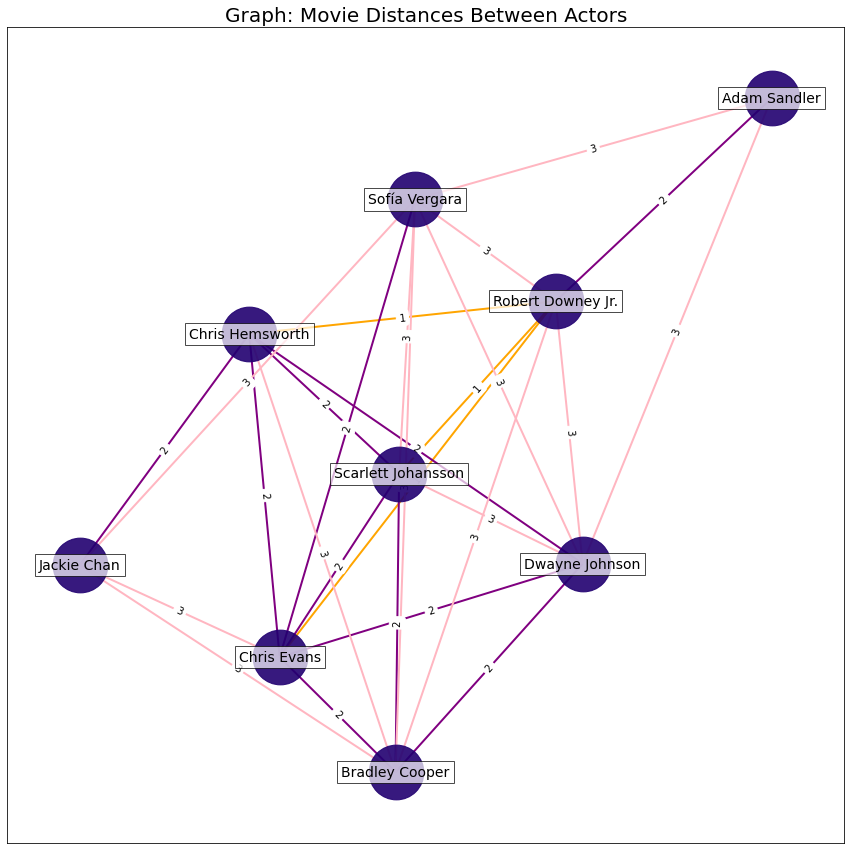

In [102]:
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="#210070", alpha=0.9)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(G, pos, font_size=14, bbox=label_options)

movie_distances = nx.get_edge_attributes(G, 'distance')

edges_by_distance = {dist: [(u, v) for (u, v, data) in G.edges(data=True) if data['distance'] == dist]
                     for dist in set(movie_distances.values())}

for distance, edges in edges_by_distance.items():
    if distance == 1:
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="orange", width=2)
    elif distance == 2:
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="purple", width=2)
    elif distance == 3:
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="lightpink", width=2)

nx.draw_networkx_edge_labels(
    G, pos, edge_labels={(u, v): data['distance'] for (u, v, data) in G.edges(data=True)}
)
    
plt.title('Graph: Movie Distances Between Actors', fontsize=20)

plt.show()

<p><strong><em>The visualised function</strong></em> takes a subgraph (a subset of edges) and a specific movie distance as input. It creates a graph using NetworkX and Matplotlib libraries and visualizes the subgraph, representing the connections between actors within the specified movie distance.</p>

In [7]:
def visualised(subgraph, distance):
    G = nx.Graph()
    G.add_edges_from(subgraph)

    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G, seed=12)
    nx.draw(G, pos, node_size=3000, node_color="lightpink", alpha=0.9)
    label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
    nx.draw_networkx_labels(G, pos, font_size=14, bbox=label_options)
    
    edge_labels = {edge: distance for edge in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)
    plt.title(f'Graph: Movie Distance {distance} Between Actors', fontsize=20)

    plt.show()


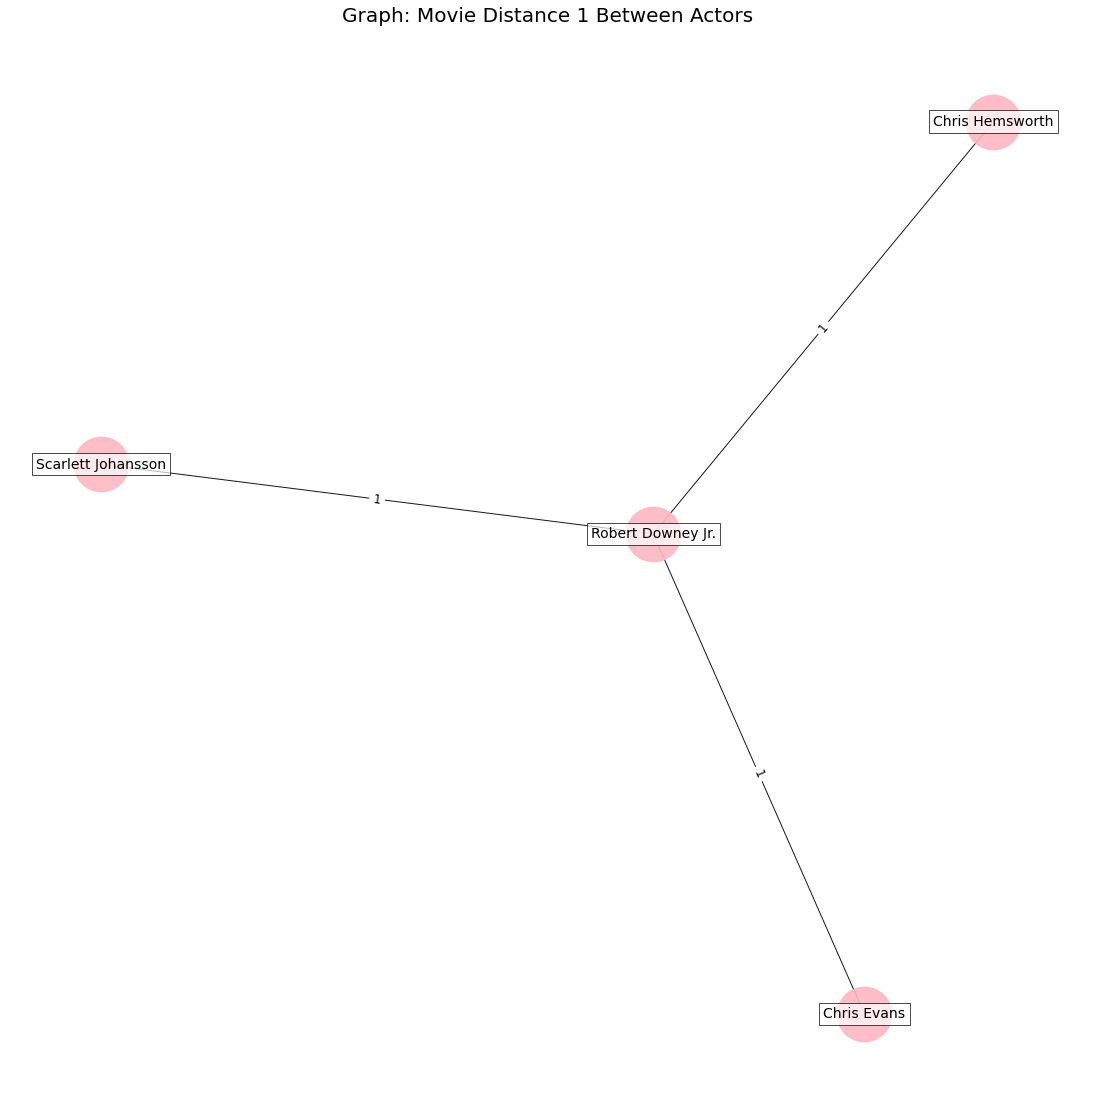

In [8]:
visualised(edges_by_distance[1], 1)

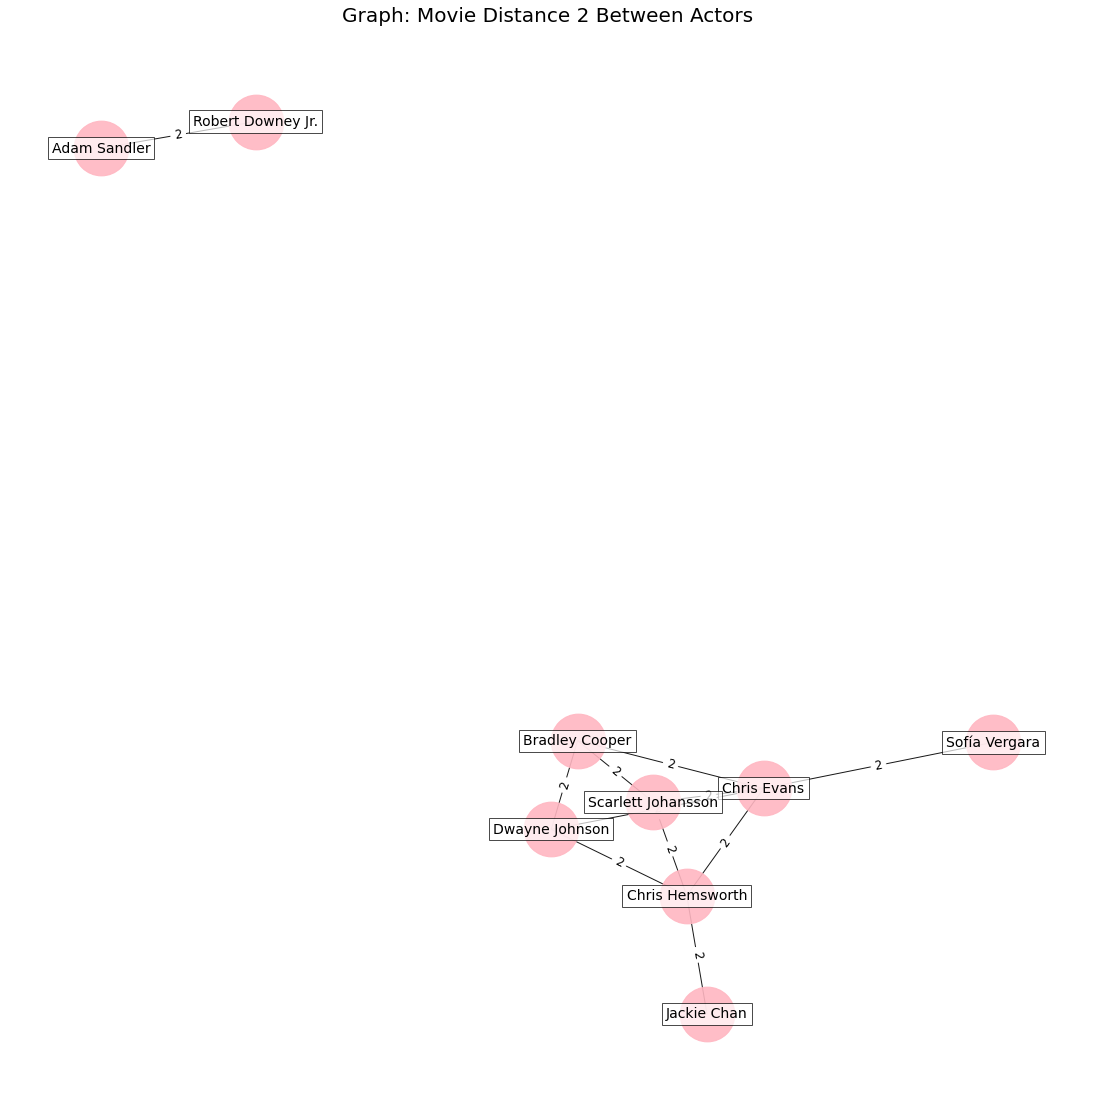

In [9]:
visualised(edges_by_distance[2], 2)

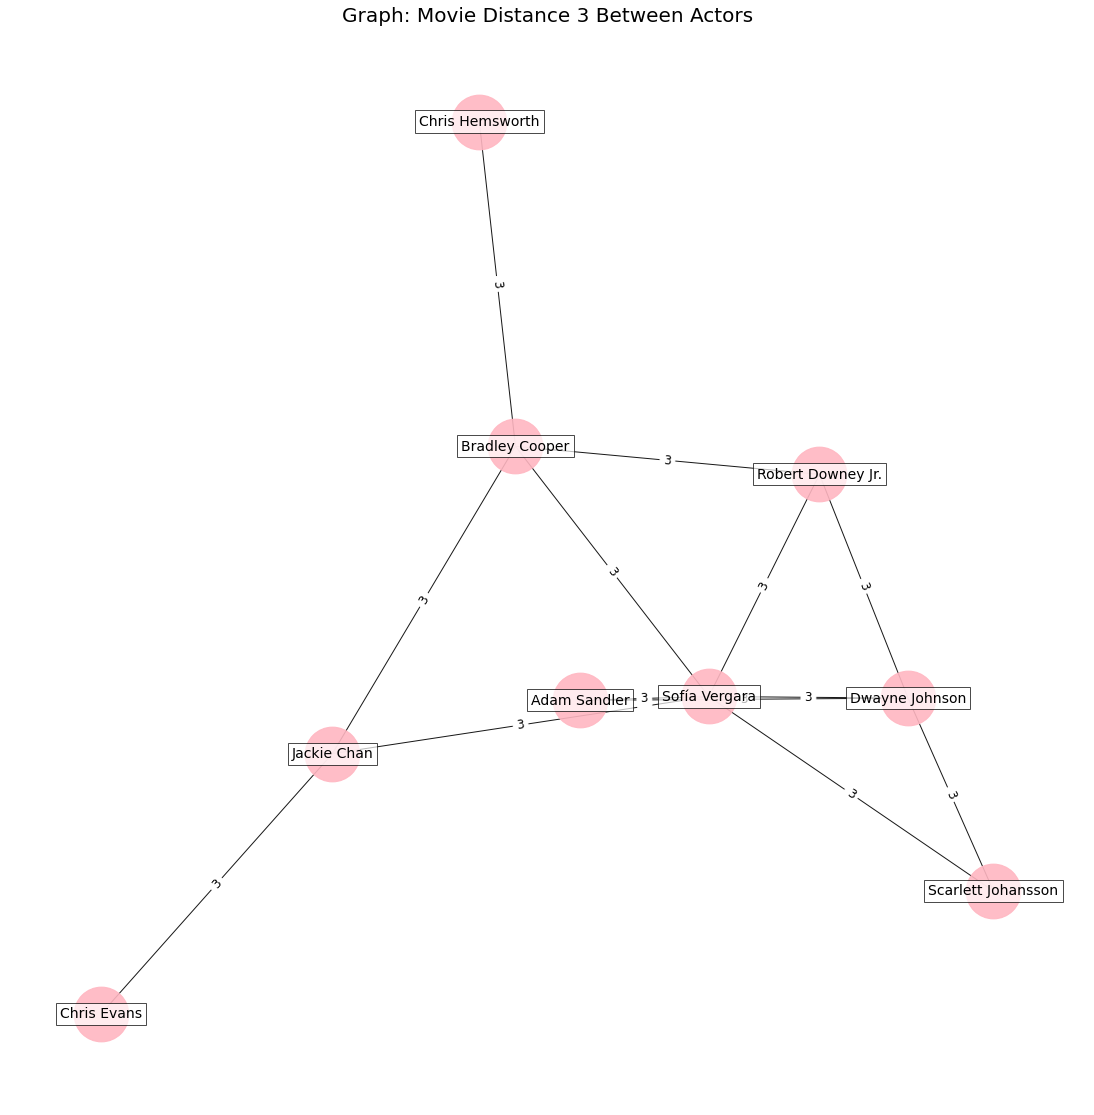

In [85]:
visualised(edges_by_distance[3], 3)

<p><strong><em>The get_movie_descriptions_by_actor_soup function</strong></em> retrieves the movie description of a film on IMDb by making an HTTP request to the film's page. It then uses BeautifulSoup to parse the response and extract the movie description from the specific HTML element with the given class and attributes. The function returns the extracted movie description as a text string.</p>

In [27]:
@functools.cache
def get_movie_descriptions_by_actor_soup(film_id):
    response = get_http(f'https://www.imdb.com/title/{film_id}/?ref_=tt_ql_1')
    soup = BeautifulSoup(response.text)
    description  = soup.find('span', class_='sc-466bb6c-2 eVLpWt', attrs={'data-testid': 'plot-xl'})
    return description.text


<p><strong><em>The preprocess_text function</strong></em> takes a text as input and performs several preprocessing steps to clean and tokenize it. It first converts the text to lowercase and removes any non-alphanumeric characters. Then, it tokenizes the text into individual words and removes common stopwords.

In [91]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tatyanaavdeenkova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [92]:
def preprocess_text(text):
    
    text = re.sub(r'[^\w\s]', '', text.lower())
    words = nltk.word_tokenize(text)

    
    stop_words = set(stopwords.words('english')) # Remove stopwords
    description = [word for word in words if word not in stop_words]

    return ' '.join(description)


<p><strong><em>The worlds_cloud function</strong></em> generates a word cloud visualization from the processed text using the WordCloud library. It sets the font path, width, and height of the resulting word cloud.</p>

In [68]:
def worlds_cloud(processed_text):
    
    font_path = "arial.ttf"
    
    width = 15
    height = 15
    
    wordcloud = WordCloud(
        width=800,
        height=500,
        background_color="white",
        font_path=font_path,
        max_font_size=50,
        max_words=100
    ).generate(processed_text)
    
    
    plt.figure(figsize=(width, height))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    

<p><strong><em>The building_cloud_helper function</strong></em> reads the content from a file named file_name, preprocesses the text using the preprocess_text function to remove stopwords and other unwanted characters, and then generates and displays a word cloud of the processed text using the worlds_cloud function.</p>

In [56]:
def building_cloud_helper(file_name):
    with open(file_name, "r") as csv_file:
        words = csv_file.read()
        processed_text = preprocess_text(words)
        worlds_cloud(processed_text)

<p><strong><em>The helper_word_cloud function</strong></em> takes an output file and an actor ID as input. It retrieves movie descriptions related to the actor from IMDb using the get_movies and get_movie functions, and then writes the concatenated descriptions into the output file. This function allows for collecting movie descriptions for a specific actor in the output file, which can be used later for word cloud visualization or other analyses.</p>

In [90]:
def helper_word_cloud(output_file, actor_id):
        
    film = (get_movies(actor_id, num_of_movies_limit=100))
    descriptions = ''
        
    for title, film_id in film:
        descriptions += get_movie(film_id)

    output_file.write(descriptions)
    output_file.flush()


In [88]:
def writing_description(): 
    actors = [
            ('Dwayne Johnson', 'nm0425005'),
            ('Chris Hemsworth', 'nm1165110'),
            ('Robert Downey Jr.', 'nm0000375'),
            ('Jackie Chan', 'nm0000329'),
            ('Bradley Cooper', 'nm0177896'),
            ('Adam Sandler', 'nm0001191'),
            ('Scarlett Johansson', 'nm0424060'),
            ('Sofía Vergara', 'nm0005527'),
            ('Chris Evans', 'nm0262635')
        ]
    file_name = []

    for actor, _id in actors:
        with open(f'words_{actor}.txt', 'w', newline='') as output_file:
            file_name.append(f'words_{actor}.txt')
            helper_word_cloud(output_file, _id)
    return file_name

In [82]:
file_name = writing_description()

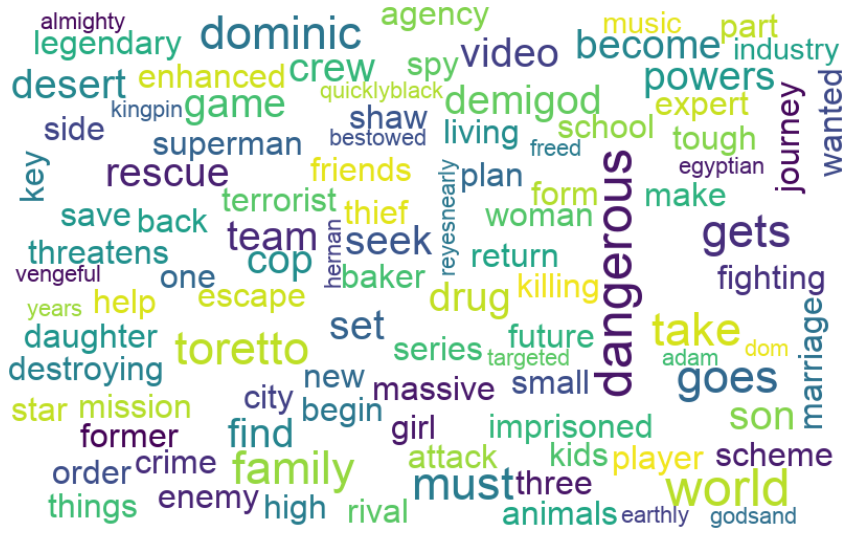

In [93]:
building_cloud_helper(file_name[0]) # Dwayne Johnson wordcloud 

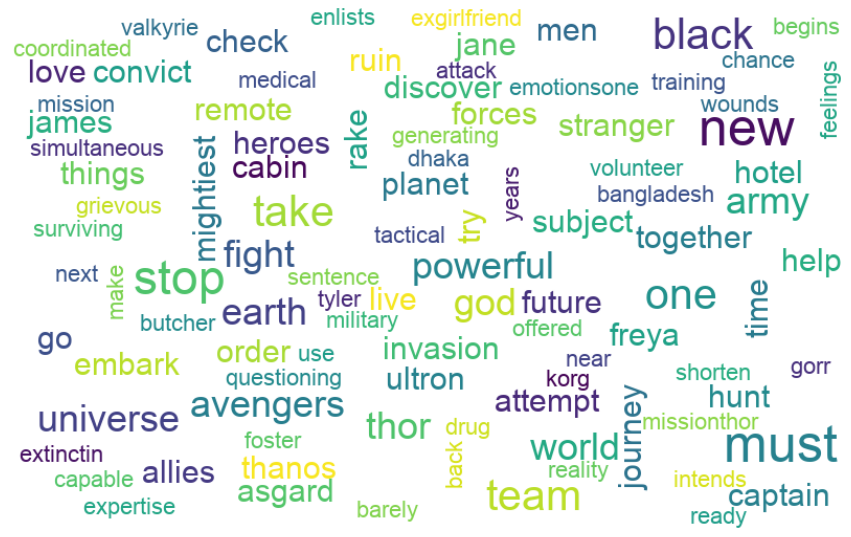

In [94]:
building_cloud_helper(file_name[1]) # Chris Hemsworth wordcloud 

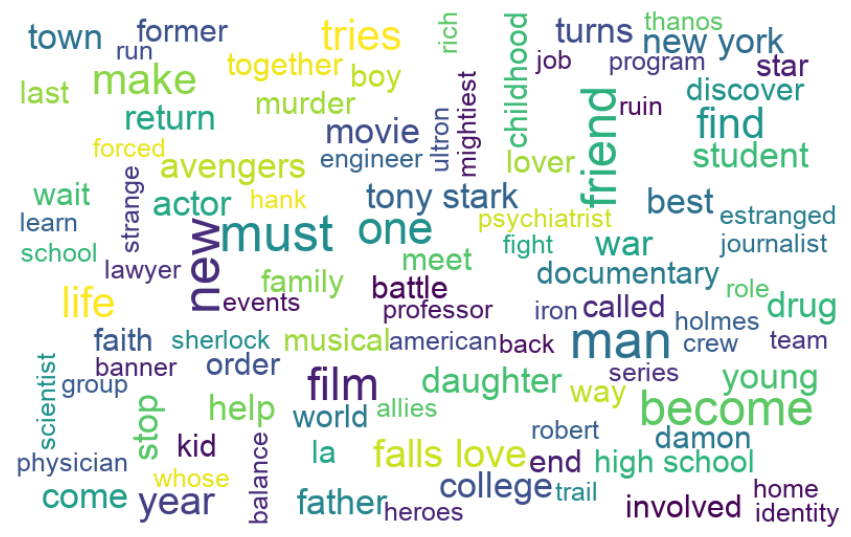

In [95]:
building_cloud_helper(file_name[2]) # Robert Downey Jr. wordcloud 

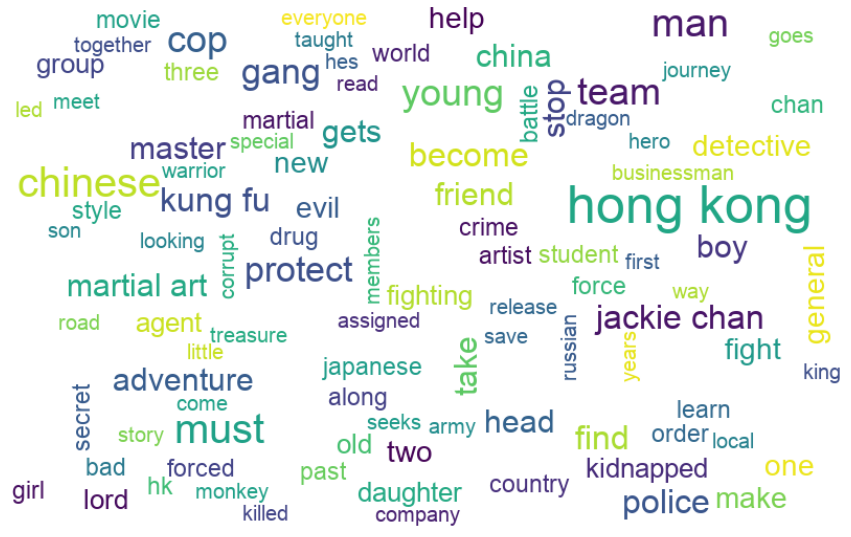

In [96]:
building_cloud_helper(file_name[3]) # Jackie Chan wordcloud 

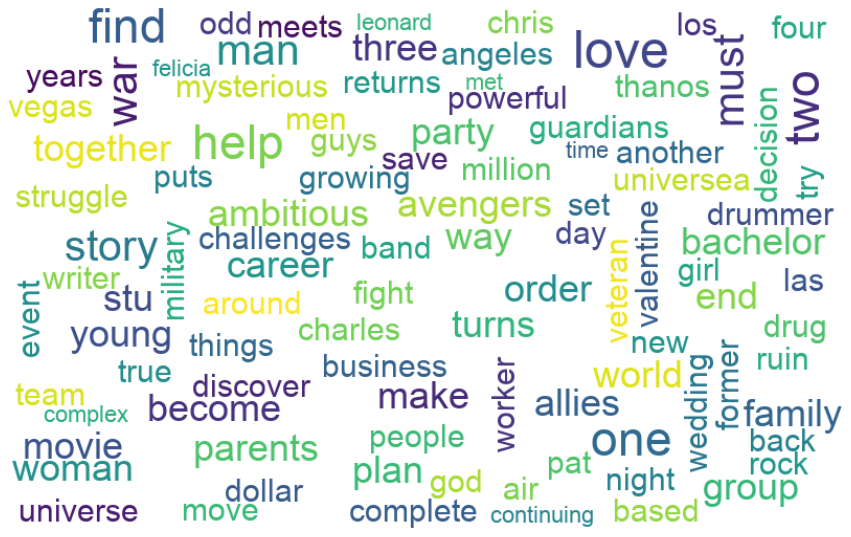

In [97]:
building_cloud_helper(file_name[4]) # Bradley Cooper wordcloud 

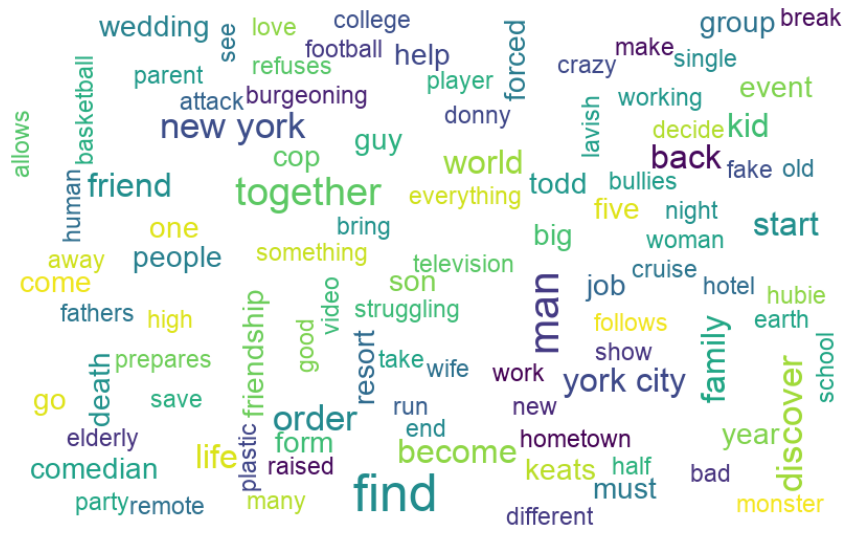

In [98]:
building_cloud_helper(file_name[5]) # Adam Sandler wordcloud 

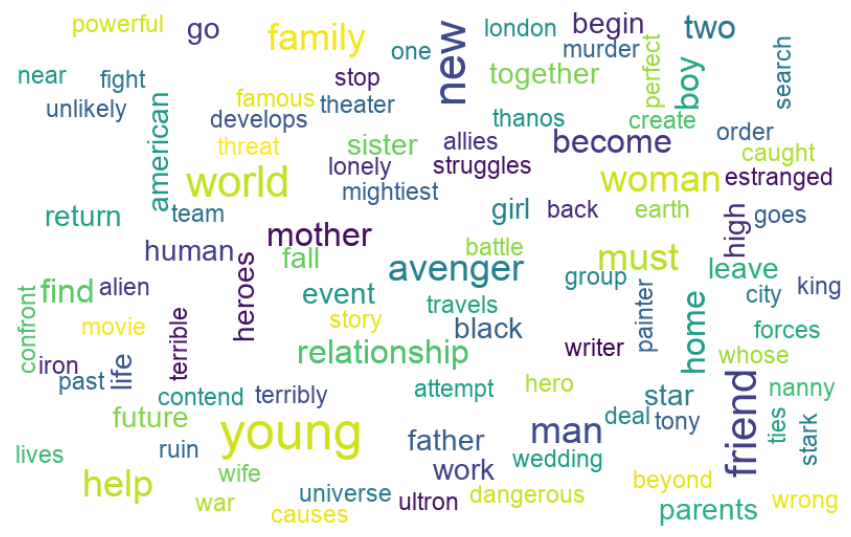

In [99]:
building_cloud_helper(file_name[6]) # Scarlett Johansson wordcloud 

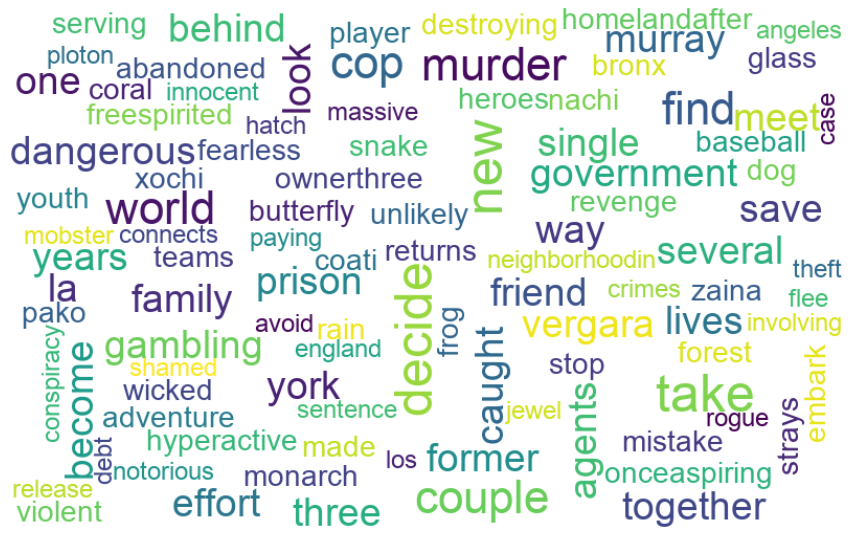

In [100]:
building_cloud_helper(file_name[7]) # Sofía Vergara wordcloud 

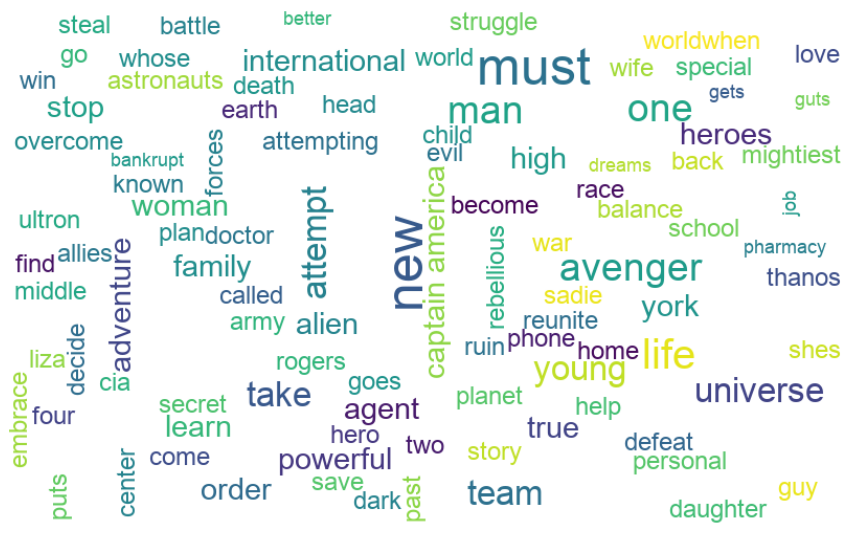

In [101]:
building_cloud_helper(file_name[8]) # Chris Evans wordcloud